<a href="https://colab.research.google.com/github/gautam-pai/Handwritten-Digit-Recognition/blob/main/Hand_Written_Number_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Importing datasets

In [2]:
train_data=datasets.USPS(root='./usps_data_train',train=True,transform=transforms.ToTensor(),download=True)

In [3]:
test_data=datasets.USPS(root='./usps_data_test',train=False,transform=transforms.ToTensor(),download=True)

In [4]:
train_data

Dataset USPS
    Number of datapoints: 7291
    Root location: ./usps_data_train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset USPS
    Number of datapoints: 2007
    Root location: ./usps_data_test
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader=DataLoader(dataset=train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(dataset=test_data,batch_size=10,shuffle=False)

## Data Exploration

In [7]:
sample=train_data[100]
sample

(tensor([[[0.0000, 0.0039, 0.0510, 0.2000, 0.4431, 0.6392, 0.6941, 0.6824,
           0.6196, 0.5020, 0.3529, 0.1922, 0.0588, 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0353, 0.2039, 0.5176, 0.7216, 0.7294, 0.6588, 0.6235,
           0.6235, 0.6353, 0.6392, 0.5294, 0.2235, 0.0392, 0.0000, 0.0000],
          [0.0039, 0.0941, 0.4039, 0.7020, 0.6118, 0.3569, 0.2157, 0.1843,
           0.1961, 0.2588, 0.4588, 0.6431, 0.3765, 0.0824, 0.0039, 0.0000],
          [0.0078, 0.1333, 0.5098, 0.6824, 0.3490, 0.0902, 0.0196, 0.0118,
           0.0118, 0.0471, 0.2431, 0.4941, 0.3137, 0.0706, 0.0039, 0.0000],
          [0.0078, 0.1255, 0.4863, 0.6392, 0.2667, 0.0353, 0.0000, 0.0000,
           0.0000, 0.0157, 0.0980, 0.2118, 0.1608, 0.0549, 0.0078, 0.0000],
          [0.0039, 0.0863, 0.3882, 0.6431, 0.3765, 0.0863, 0.0078, 0.0039,
           0.0314, 0.1098, 0.2118, 0.3020, 0.3176, 0.1882, 0.0471, 0.0000],
          [0.0000, 0.0353, 0.2314, 0.5608, 0.5490, 0.2392, 0.0627, 0.0824,
           0.2196, 

In [8]:
sample_image,sample_tag=sample[0],sample[1]

In [9]:
sample_image.shape

torch.Size([1, 16, 16])

Text(0.5, 1.0, 'Tag for the image is 8')

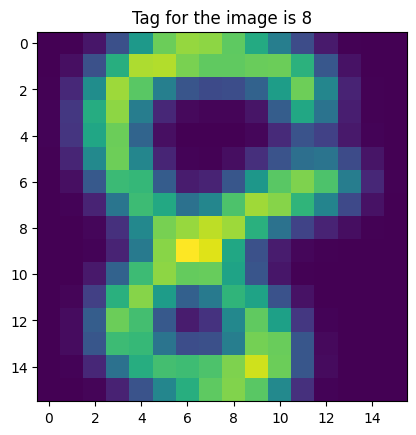

In [10]:
plt.imshow(sample_image.reshape(16,16))
plt.title(f'Tag for the image is {sample_tag}')

## Neural Network Model

In [11]:
class NumberDetector(nn.Module):
  def __init__(self):
    super().__init__()
    ## Convolutional Layers - The first in_channel is so that 1 image in 1 channel is passed, The remaining 10,20,30 are arbitrarily chosen
    self.conv1=nn.Conv2d(in_channels=1,out_channels=10,kernel_size=3,stride=1)
    self.conv2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3,stride=1)
    self.conv3=nn.Conv2d(in_channels=20,out_channels=30,kernel_size=3,stride=1)

    ## Fully Connected Layers
    self.fc1=nn.Linear(30*10*10,out_features=100) # Since the output of Convolution will be a 10*10 image across 30 channels in-features will be 30*10*10.  The out features is also arbitrarily chosen.
    self.fc2=nn.Linear(100,50) # The output of previous linear layer is 100, so input here will be 100. And output we've arbitrarily chosen as 50
    self.fc3=nn.Linear(50,10) # we want the final output to be 10, because there are 10 digits possible.

  def forward(self,X):
    # First convolution and relu activation
    X=F.relu(self.conv1(X))
    # Second Convolution and relu activation
    X=F.relu(self.conv2(X))
    # Third Convolution and relu activation
    X=F.relu(self.conv3(X))

    ## Flattening
    X=X.view(-1,30*10*10)

    # ANN Layers/ Neural Networks
    X=F.relu(self.fc1(X))
    X=F.relu(self.fc2(X))
    X=self.fc3(X)

    return F.log_softmax(X,dim=1)



In [12]:
Detector=NumberDetector()

In [13]:
Detector

NumberDetector(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3000, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

## Loss Function Optimizer

In [14]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(Detector.parameters(),lr=0.01)

## Training the model

In [15]:
import time
start_time=time.time()
epochs=10
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]


for i in range(epochs):
  trn_corr=0
  tst_corr=0
  ## Train Data
  for b,(X_Train,y_train) in enumerate(train_loader):
    b+=1
    y_pred=Detector(X_Train)
    loss=criterion(y_pred,y_train)

    predicted=torch.max(y_pred.data,1)[1]
    batch_corr=(predicted==y_train).sum()
    trn_corr+=batch_corr

    ## Optimization of weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printing the loss % after certain number of data has been used to train
    if b%100==0:
      print(f'Epoch: {i}  Batch: {b}  Loss:{loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

    ## Testing
  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val=Detector(X_test)
      predicted=torch.max(y_val.data,1)[1]
      tst_corr+=(predicted==y_test).sum()

  loss=criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time=time.time()
print(f'Total time taken to finish the training = {(current_time-start_time)/60 } mins')

Epoch: 0  Batch: 100  Loss:0.38786306977272034
Epoch: 0  Batch: 200  Loss:0.0828697457909584
Epoch: 0  Batch: 300  Loss:0.12129299342632294
Epoch: 0  Batch: 400  Loss:0.17492346465587616
Epoch: 0  Batch: 500  Loss:0.12109380960464478
Epoch: 0  Batch: 600  Loss:0.9311702847480774
Epoch: 0  Batch: 700  Loss:0.2927468419075012
Epoch: 1  Batch: 100  Loss:0.45130640268325806
Epoch: 1  Batch: 200  Loss:0.14682558178901672
Epoch: 1  Batch: 300  Loss:0.019609767943620682
Epoch: 1  Batch: 400  Loss:0.012339687906205654
Epoch: 1  Batch: 500  Loss:0.008576289750635624
Epoch: 1  Batch: 600  Loss:0.00021882021974306554
Epoch: 1  Batch: 700  Loss:0.027331341058015823
Epoch: 2  Batch: 100  Loss:1.704598069190979
Epoch: 2  Batch: 200  Loss:0.08355977386236191
Epoch: 2  Batch: 300  Loss:0.014341223053634167
Epoch: 2  Batch: 400  Loss:0.20232000946998596
Epoch: 2  Batch: 500  Loss:0.1367793083190918
Epoch: 2  Batch: 600  Loss:0.02791321650147438
Epoch: 2  Batch: 700  Loss:0.055565185844898224
Epoch: 3  

## Loss Visualization

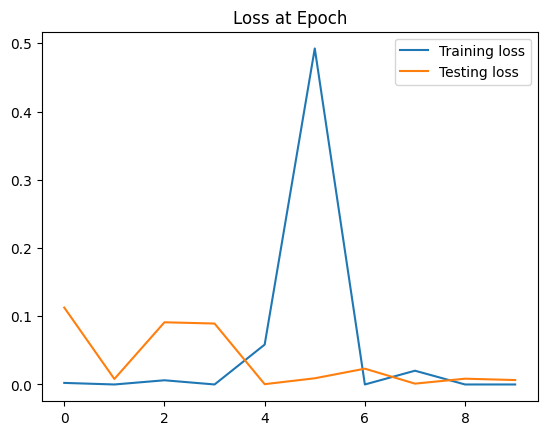

In [16]:
train_losses= [tl.item() for tl in train_losses]

plt.plot(train_losses,label="Training loss")
plt.plot(test_losses,label="Testing loss")
plt.title("Loss at Epoch")
plt.legend()

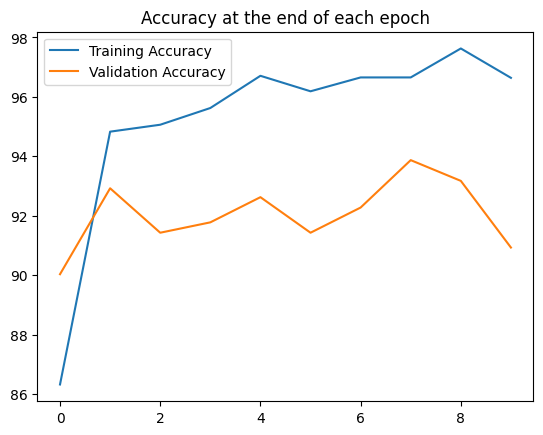

In [17]:
# Accuracy at the end of each epoch

plt.plot([t/72.91 for t in train_correct],label="Training Accuracy")
plt.plot([t/20.07 for t in test_correct],label="Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

## Accuracy with Testing Data

In [18]:
with torch.no_grad():
  correct=0
  for X_test,y_test in test_loader:
    y_val=Detector(X_test)
    predicted=torch.max(y_val,1)[1]
    correct+=(predicted==y_test).sum()
print(f"{(correct.item()/len(test_data))*100} %")

90.9317389138017 %


## Random Digit Test

In [19]:
test_data

Dataset USPS
    Number of datapoints: 2007
    Root location: ./usps_data_test
    StandardTransform
Transform: ToTensor()

In [20]:
sample_image,sample_tag=test_data[1900][0],test_data[1900][1]

In [21]:
sample_image

tensor([[[0.0000, 0.0000, 0.0000, 0.0157, 0.1098, 0.3216, 0.5373, 0.6275,
          0.4510, 0.2235, 0.0667, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039, 0.0784, 0.3412, 0.6941, 0.8784, 0.8941,
          0.7412, 0.5412, 0.2627, 0.0784, 0.0118, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0353, 0.2275, 0.6196, 0.9059, 0.9765, 0.9020,
          0.6941, 0.5843, 0.5059, 0.3020, 0.0941, 0.0118, 0.0000, 0.0000],
         [0.0000, 0.0078, 0.1216, 0.4706, 0.8314, 0.9647, 0.9412, 0.7686,
          0.4275, 0.3216, 0.5333, 0.5961, 0.3294, 0.1020, 0.0157, 0.0000],
         [0.0000, 0.0314, 0.2471, 0.6941, 0.9412, 0.9373, 0.7647, 0.4902,
          0.1804, 0.1137, 0.3686, 0.6784, 0.6510, 0.3490, 0.0902, 0.0078],
         [0.0039, 0.0784, 0.3843, 0.8118, 0.9647, 0.8353, 0.4706, 0.1804,
          0.0392, 0.0275, 0.1725, 0.5294, 0.8000, 0.6471, 0.2510, 0.0392],
         [0.0078, 0.1333, 0.5216, 0.8784, 0.9333, 0.6824, 0.2549, 0.0431,
          0.0039, 0.0039, 0.0667

In [22]:
sample_tag

0

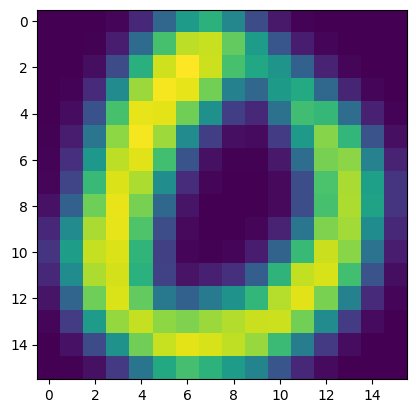

In [23]:
plt.imshow(sample_image.reshape(16,16))

In [24]:
Detector.eval()
with torch.no_grad():
  new_predict=Detector(test_data[1900][0].view(1,1,16,16))

In [25]:
new_predict

tensor([[   0.0000, -107.4791,  -29.2579,  -30.0010,  -43.0733,  -21.5747,
          -24.8737,  -24.1743,  -44.4631,  -51.8960]])

In [26]:
new_predict.argmax()

tensor(0)

## Random Digit Testing - 2

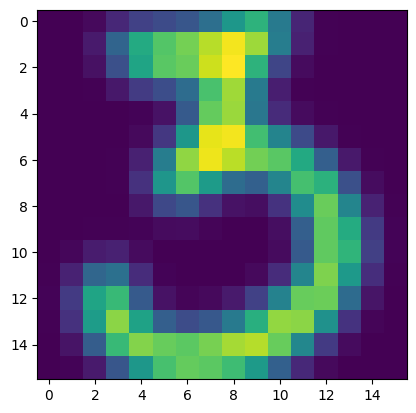

In [27]:
sample_image,sample_tag=test_data[500][0],test_data[500][1]
plt.imshow(sample_image.reshape(16,16))
Detector.eval()
with torch.no_grad():
  new_predict=Detector(sample_image.view(1,1,16,16))

In [28]:
new_predict

tensor([[-1.2692e+01, -3.0519e+01, -1.1143e+01, -8.1770e-03, -1.8249e+01,
         -4.8146e+00, -2.4667e+01, -1.1104e+01, -1.4585e+01, -1.6406e+01]])

In [29]:
new_predict.argmax()

tensor(3)

## Accuracy on Overall Test Data

In [30]:
with torch.no_grad():
  correct=0
  for X_test,y_test in test_loader:
    y_pred=Detector(X_test)
    predicted=torch.max(y_pred,1)[1]
    correct+=(predicted==y_test).sum()

print(f"Accuracy on Test Data: {correct.item()/len(test_data)}")

Accuracy on Test Data: 0.909317389138017
